In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ravdess-emotional-speech-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107620%2F256618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240210%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240210T140626Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9f5d5cce495a5acc393d65a2bfbdb42fc8161021bc475038a654e37229870cb967ef455878a208574e289b0d95a2e8a4a156896ff3bd317c07e0bdd6ca2a565e4a77cf0b7d4fe004553f31ec1ec601adf72fcc0f8ee073ade3cdd1533dff9d4e2de7d6b545ea875a6ce90c6440d37975c78c61e31dee23111ada47780a0442e4efd621727dd83cbfb5137215a58a591a352d5ad338880a2536570f83c49251cde6372d68c68d3387621e230cef7632f1fd9441a39d0de56ca8d25a02708dfca401d91956b43fdeb3ccaf670e5fed62ba26022ab5c331305525248e71e6f8340d23f415c70f42ca38b440b94dddc39546b1ccc9b396becbfd48495af2e57788ee,toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240210%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240210T140626Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9c8448a8b7979b2c6447e5af0e9f18ea36ffb13af4966d2a67cb0f00afd6690584074544043e63d8125fc3034fc521cc5eb6ad7d4b74785f212e1710507ee01f45b6d3638b7cc718d894a557c95304433b7c016e44c7efc10de93b1db3dd9a1b7dbb193c5e52ffde415a86b8418be785424d006a0789f4eaa93b8b2db33aa218a49a5a4f93cc31b702a4f1419d4c42fd30cb051e40b4514fbb20afd5cfa197d0bb4fba46c0fb5fbe17a4636014482df63ab9c60fc7f77c5d89a2ba90fa4f578e82eb287b84dd47a02108589bf671203c4f244d53d79b0123dba2d31ccb59aebf4d59fbd3ccc2b438d7b1ca35aca4fea9c2ba2855c72dc640de064e24d7ffe8ad,cremad:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F325566%2F653195%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240210%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240210T140626Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9908fd8000d15f98bc1beeaa4c3c264a70919a31eaaa0b97e546ca7c5cc260831d225e2d851b3bb6f4896b0a4f14742c54dd9fb9e35d6deaf150fd490f1c4c8e6d5226aef36f4ee45526ffcf71135c2b4a958011a677e771c09d04826d75330c80d846d20f4f103d8ecf08bfe6874350e4372c61000fb6dc387347d03813f3c866685c535ab74c81ea0d541a43b24c3a7193a9c8f0cacc5722a6511010f85c4b052cc1ee8396d4055c42369d5a19d80154e93519c71bd6478154c221cb8af5bac14ef77d9f72647c220a4bdb43636da15a2c2d4f9978ad9898aaccde3f66016a8fee179b97ac791e1a6bd9461db129b034505511c03d31cc28c21e8486443397,surrey-audiovisual-expressed-emotion-savee:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F338555%2F671851%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240210%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240210T140626Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9355b1aba69fadeb879d1b38c7a60462e9d6bf41734fcf6d032b1114c797fd808922476e182b74ca12f62817ae59bb1748ba5cf62beadffa12cebec5a6e7ed3bb059c69ca1eb68265a9a9d599e8cb817d171060622f548f2d45a93d23f478a370214d9d02e09f31554f3c6bfc85ddd41e9779bf31150ac7bb85624bdff6b1ba33fd4e4afd0c029eb8112a01c93efa67e9339422025af65dcb9c11c55bbc72aa030d46409035fa11c37b698215dcb16801a2026c8f3a20d259ed2fddf5c9f990ddaafb7858bfb9108930e1ad122bccca748980b555729d47fa56006e0d8146218c0ce1ec34d8b9baae0b817c458d7be831e1a00a32ece7445a87454604215d965'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 450102890 bytes downloaded
Downloaded and uncompressed: ravdess-emotional-speech-audio
[==================================================] 448572034 bytes downloaded
Downloaded and uncompressed: toronto-emotional-speech-set-tess
[==================================================] 473324524 bytes downloaded
Downloaded and uncompressed: cremad
[==================================================] 112690765 bytes downloaded
Downloaded and uncompressed: surrey-audiovisual-expressed-emotion-savee
Data source import complete.


# Speech Emotion Recognition

The objective of this notebook is to classify from raw sound waves to six emotions: happy, sad, neutral, fear, angry, and disgust.

1. Gathering data
2. Quick EDA
3. Preprocess
4. Extract features
5. Build a LSTM
6. Evaluate and conclude

Datasets:
* Crowd-sourced Emotional Multimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto Emotional Speech Set (Tessa)

# 1. Gathering data

We will gather speech data from four datasets and store it in a single dataframe along with the corresponding file paths, gender labels and emotion labels. The size of each respective dataframe will be specified, along with an example filename in which the emotion label is bolded.

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
RAVDESS = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
CREMA = "/kaggle/input/cremad/AudioWAV/"
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

**1. Ravdess Dataframe**

There are 1440 audio files, for example, 03-01-**06**-01-02-01-12.wav.

In [5]:
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files:
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])

ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,sad
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,sad
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,sad
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,happy
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,angry


**2. Crema-D Dataframe**

There are 7,442 audio files, for example, 1001_DFA_**ANG**_XX.wav.

In [6]:
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018',
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047',
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072',
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav':
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema_df.head()

,path,sex,emotion
0,/kaggle/input/cremad/AudioWAV/1007_IEO_SAD_HI.wav,female,sad
1,/kaggle/input/cremad/AudioWAV/1090_IEO_SAD_HI.wav,male,sad
2,/kaggle/input/cremad/AudioWAV/1023_IEO_SAD_HI.wav,male,sad
3,/kaggle/input/cremad/AudioWAV/1072_IEO_HAP_HI.wav,female,happy
4,/kaggle/input/cremad/AudioWAV/1087_IEO_DIS_HI.wav,male,disgust


**3. Tess Dataframe**

There are 2,800 audio files, for example, OAF_base_**fear**.wav.

In [7]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{TESS}{directory}/{audio_file}")
            gender_list.append('female') # female only dataset
            emotion_list.append(emotion_dic[key])

tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess_df.head()

,path,sex,emotion
0,/kaggle/input/toronto-emotional-speech-set-tes...,female,happy
1,/kaggle/input/toronto-emotional-speech-set-tes...,female,happy
2,/kaggle/input/toronto-emotional-speech-set-tes...,female,happy
3,/kaggle/input/toronto-emotional-speech-set-tes...,female,happy
4,/kaggle/input/toronto-emotional-speech-set-tes...,female,happy


**4. Savee Dataframe**

There are 480 audio files, for example, DC_**a**02.wav.

In [8]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])

savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee_df.head()

,path,sex,emotion
0,/kaggle/input/surrey-audiovisual-expressed-emo...,male,angry
1,/kaggle/input/surrey-audiovisual-expressed-emo...,male,neutral
2,/kaggle/input/surrey-audiovisual-expressed-emo...,male,sad
3,/kaggle/input/surrey-audiovisual-expressed-emo...,male,angry
4,/kaggle/input/surrey-audiovisual-expressed-emo...,male,sad


In [9]:
df = pd.concat([
    ravdess_df,
    crema_df,
    tess_df,
    savee_df
], axis=0)
df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,sad
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,sad
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,sad
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,happy
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,angry


# 2. Quick EDA

We check for imbalances like male to female ratio.

In [10]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

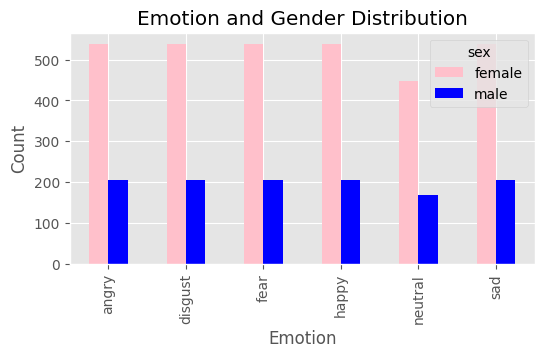

In [11]:
def plot_distribution(df):
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()

plot_distribution(df)

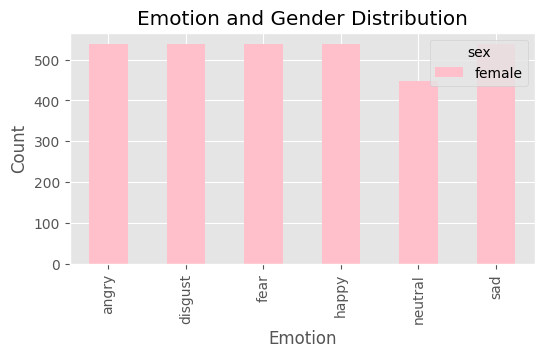

In [12]:
# I decided to go with a female specific model
df = df[df['sex'] == 'female']
plot_distribution(df)

In [13]:
df.drop('sex', axis=1, inplace=True)
df.head()

,path,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,sad
1,/kaggle/input/ravdess-emotional-speech-audio/a...,sad
2,/kaggle/input/ravdess-emotional-speech-audio/a...,sad
3,/kaggle/input/ravdess-emotional-speech-audio/a...,happy
4,/kaggle/input/ravdess-emotional-speech-audio/a...,angry


In [14]:
from IPython.display import Audio

def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()

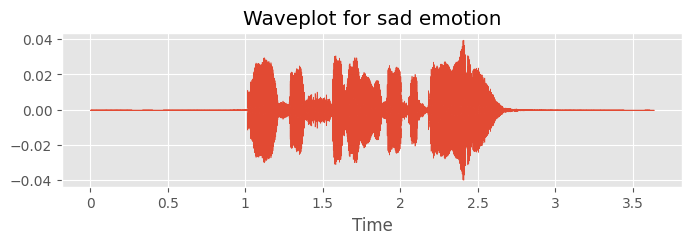

In [15]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
Audio(path)

# 3. Preprocess

The following steps will be followed to preprocess the audio:

1. Get an array of samples
2. Trim the silence  
3. Padding for equal length

In [16]:
!pip install pydub
from pydub import AudioSegment, effects

In [17]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)

    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [18]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2,
    'angry'   : 3,
    'fear'    : 4,
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

# 4. Extract features

We will only extract these features:

1. Mel-Frequency Cepstral Coefficients: captures the shape of the spectral envelope of a signal
2. Zero Crossing Rate: captures the number of times a signal changes sign per second
3. Root Mean Square Energy: captures the root mean square amplitude of the audio signal

In [19]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try:
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav


In [20]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

# 5. Build a LSTM

Before building the model, we will have to setup the data. LSTM are great for sequences.  

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [22]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [23]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks

In [24]:
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 352, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 53894 (210.52 KB)
Trainable params: 53894 (210.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [25]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL.fit(X_train, y_train_class, epochs=200, batch_size=6, validation_data=(X_val, y_val_class))

Epoch 1/200
461/461 [==============================] - 15s 23ms/step - loss: 1.6067 - categorical_accuracy: 0.2916 - val_loss: 1.4562 - val_categorical_accuracy: 0.4091
Epoch 2/200
461/461 [==============================] - 10s 21ms/step - loss: 1.4479 - categorical_accuracy: 0.3741 - val_loss: 1.3560 - val_categorical_accuracy: 0.4091
Epoch 3/200
461/461 [==============================] - 10s 21ms/step - loss: 1.3044 - categorical_accuracy: 0.4352 - val_loss: 1.2275 - val_categorical_accuracy: 0.4659
Epoch 4/200
461/461 [==============================] - 10s 22ms/step - loss: 1.2428 - categorical_accuracy: 0.4533 - val_loss: 1.3989 - val_categorical_accuracy: 0.4280
Epoch 5/200
461/461 [==============================] - 10s 22ms/step - loss: 1.1883 - categorical_accuracy: 0.4946 - val_loss: 1.1689 - val_categorical_accuracy: 0.4735
Epoch 6/200
461/461 [==============================] - 10s 21ms/step - loss: 1.1631 - categorical_accuracy: 0.5163 - val_loss: 1.1893 - val_categorical_acc

# 6. Evaluate and conclude

Let's see how good are model is.

In [26]:
from sklearn.metrics import confusion_matrix

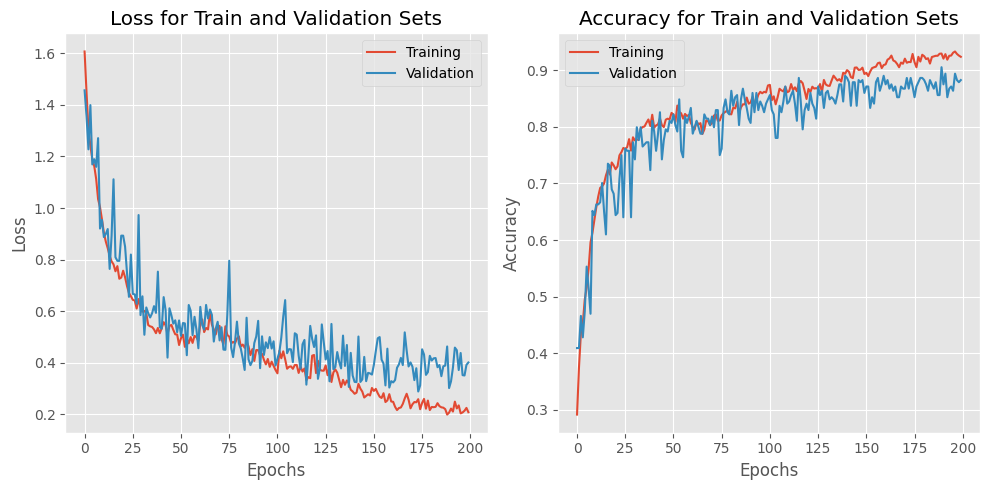

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

9/9 [==============================] - 1s 19ms/step


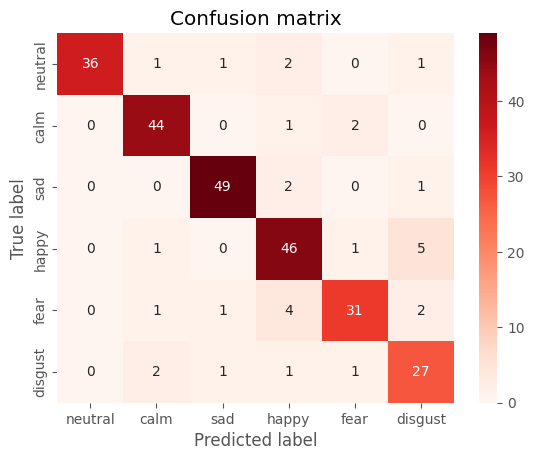

In [28]:
import seaborn as sns

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [32]:
import pickle

with open('emotion.pkl', 'wb') as f:
    pickle.dump(model, f)

**Conclusion**

In summary, our model achieved 90% accuracy in classifying six different emotions. However, there are several ways we could improve it. For example, we could change the model, obtain a better dataset and extract different features. One optimization that we could make is to generate a codebook and apply vector quantization to reduce the dimensionality. This can help to improve the model's training speed and reduce the risk of overfitting. Lastly, don't forget to use accelerators to speed up the training process.